In [1]:
import os
import time
from tqdm import tqdm

import modules.data_loader as data_loader
import modules.helper as helper
from modules.music_composer_jazz2 import LSTMModel

import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
MODEL_NAME = 'comparison'

TUNES_FILE = 'dataset/jazz/jazz_tunes1.txt'
VOCAB_FILE = 'dataset/jazz/jazz_vocab1.json'

WEIGHTS_DIR = 'weights'
WEIGHT_CHECKPOINT = "weight_improvement_{epoch:02d}_{loss:.4f}.h5"

EPOCHS = 20
BATCH_SIZE = 64
SEQ_LENGTH = 150
BUFFER_SIZE = 10000

In [3]:
ds = data_loader.ABCDatasetLoader(sequence_length=SEQ_LENGTH,
                                  batch_size=BATCH_SIZE,
                                  buffer_size=BUFFER_SIZE,
                                  text_dir=TUNES_FILE,
                                  output_dir=VOCAB_FILE)

train_data = ds.get_abc_dataset_from_text()
test_data = ds.get_abc_dataset_from_text(split='test')

vocab_length = ds.get_vocab_length()
step_size = ds.get_stepsize()
idx2char = ds.get_index2char()
char2idx = ds.get_char2index()

train_data, test_data, vocab_length

(<BatchDataset shapes: ((64, 150), (64, 150)), types: (tf.int64, tf.int64)>,
 <BatchDataset shapes: ((64, 150), (64, 150)), types: (tf.int64, tf.int64)>,
 93)

## Model

In [4]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed1 (Embedding)           (64, None, 512)           47616     
_________________________________________________________________
batch_normalization (BatchNo (64, None, 512)           2048      
_________________________________________________________________
lstm1 (LSTM)                 (64, None, 512)           2099200   
_________________________________________________________________
dropout (Dropout)            (64, None, 512)           0         
_________________________________________________________________
lstm2 (LSTM)                 (64, None, 128)           328192    
_________________________________________________________________
dropout_1 (Dropout)          (64, None, 128)           0         
_________________________________________________________________
lstm3 (LSTM)                 (64, None, 128)           1

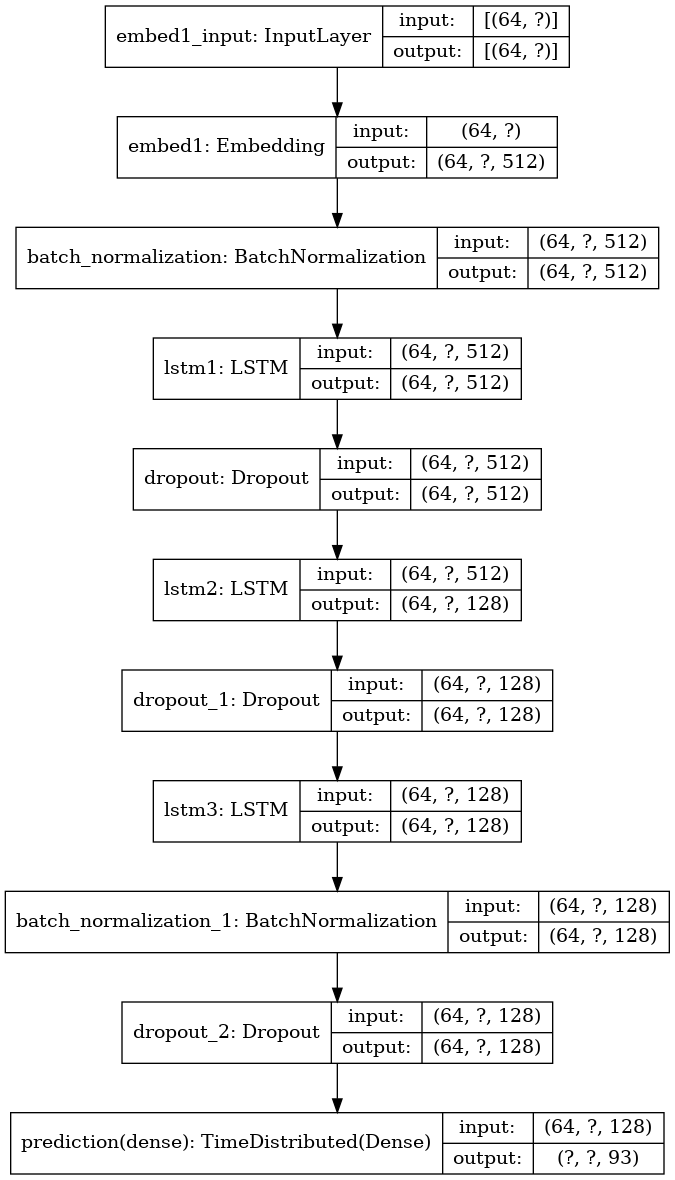

In [5]:
model = LSTMModel(vocab_size=vocab_length, batch_size=BATCH_SIZE)

model.compile(loss=loss, 
             optimizer='adam',
             metrics=['sparse_categorical_accuracy'])

model.summary()
tf.keras.utils.plot_model(model, 
                          to_file='visualization/model_{n}_{e}_{b}.png'.format(n=MODEL_NAME, e=EPOCHS, b=BATCH_SIZE), 
                          show_shapes=True, 
                          show_layer_names=True)

#### Assert model input

In [6]:
for input_example_batch, target_example_batch in train_data.take(1):
    example_batch_predictions = model(input_example_batch)
    print("Input: \n", repr(input_example_batch))
    print("Target: \n", repr(target_example_batch))
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

Input: 
 <tf.Tensor: shape=(64, 150), dtype=int64, numpy=
array([[16,  2, 91, ..., 17,  1, 54],
       [39, 13, 21, ..., 89, 19,  2],
       [37, 16, 14, ...,  2,  2,  2],
       ...,
       [91,  2,  4, ...,  2,  2,  2],
       [ 2, 91,  2, ..., 89, 21,  2],
       [35, 25,  2, ..., 89, 25,  2]])>
Target: 
 <tf.Tensor: shape=(64, 150), dtype=int64, numpy=
array([[ 2, 91,  2, ...,  1, 54, 27],
       [13, 21,  2, ..., 19,  2,  4],
       [16, 14,  2, ...,  2,  2,  2],
       ...,
       [ 2,  4, 36, ...,  2,  2,  2],
       [91,  2,  4, ..., 21,  2,  4],
       [25,  2,  2, ..., 25,  2,  2]])>
(64, 150, 93) # (batch_size, sequence_length, vocab_size)


#### Model sample prediction

In [7]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([43, 84, 33, 48, 13, 39, 47,  0, 33,  6, 62, 14, 67,  1, 22,  7, 59,
       20, 72, 88, 91, 64, 61,  2, 64, 44, 53, 10, 57, 26, 50, 14,  4, 69,
       39, 69, 63,  2,  2, 89, 63, 56, 51, 68, 88, 25,  1, 74, 49, 74,  1,
       40, 88, 27, 11, 84, 18, 84,  8, 15, 76,  5, 80, 87, 13, 92, 17, 39,
        2, 18, 30, 76, 67, 24, 77, 90, 66, 70, 85,  0, 54, 90, 25, 35, 38,
       62, 16, 28, 19, 19, 63, 77, 41, 59, 54, 10, 47, 14, 40, 73, 42, 24,
       45, 88, 37, 42, 40, 19, 13, 53, 28, 72, 84, 66, 16, 24, 29, 54, 87,
       74, 59, 47,  0,  5, 28,  2, 45, 76, 81, 45, 17,  9, 14, 72, 32, 28,
       31,  7, 59,  9, 50, 52,  1, 89, 34, 43, 16, 42, 73, 79])

In [8]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 '/ | z>=a-a2 | g/=a/g/e/ de ||\n\n\nX:3\nT:Central Park West\nM:4/4\nL:1/4\nC:John Coltrane\nQ:1/4=80\n%%staves (chords melody)\nK:B\n%%text (ballad)\n%%vskip 20\nV'

Next Char Predictions: 
 'KuAP,GO\tA%^-d\n5&[3iy|a] aLU)Y9R-"fGf_  z_XSey8\nkQk\nHy:*u1u\'.m#qx,}0G 1=md7n{cgv\tV{8CF^/;22_nI[V)O-HjJ7MyEJH2,U;iuc/7<Vxk[O\t#; MmrM0(-i@;>&[(RT\nzBK/Jjp'


## Train Model

In [9]:
def training(model, epochs, step_size):
    
    history = {}
    loss, accuracy, val_loss, val_accuracy = [], [], [], []

    for epoch in range(epochs):
        
        print("Epoch {}/{}".format(epoch+1, epochs))
        final_epoch_loss, final_epoch_accuracy = 0, 0

        with tqdm(total=step_size) as pbar:
            # Training
            for batch_n, (inp, target) in enumerate(train_data):
                final_epoch_loss, final_epoch_accuracy = model.train_on_batch(inp, target)
                pbar.update(1)            
            
            # Validating
            for batch_n, (inp, target) in enumerate(test_data):
                final_epoch_val_loss, final_epoch_val_accuracy = model.test_on_batch(inp, target)

            print("Epoch: {}, Loss: {}, Accuracy: {}, Val-Loss: {}, Val-Accuracy: {}".format(epoch+1, 
                                                                                 final_epoch_loss, final_epoch_accuracy,
                                                                                 final_epoch_val_loss, final_epoch_val_accuracy))
            
            loss.append(final_epoch_loss)
            accuracy.append(final_epoch_accuracy)
            val_loss.append(final_epoch_val_loss)
            val_accuracy.append(final_epoch_val_accuracy)

            #saving weights after every 5 epochs
            if (epoch + 1) % 5 == 0:
                if not os.path.exists(WEIGHTS_DIR):
                    os.makedirs(WEIGHTS_DIR)
                model.save_weights(os.path.join(WEIGHTS_DIR, WEIGHT_CHECKPOINT).format(epoch = epoch+1, loss=final_epoch_loss))
                print('Saved Weights at epoch {}'.format(epoch+1))
                
    history = {
    'loss' : loss,
    'accuracy' : accuracy,
    'val_loss' : val_loss,
    'val_accuracy' : val_accuracy
    }
    
    return history


In [10]:
def evaluate(model, data):
    history = {}
    
    for batch_n, (inp, target) in enumerate(data):
        loss, acc = model.test_on_batch(inp, target)
        
    history = {'loss' : loss, 'accuracy' : acc}
    return history

In [11]:
# model.load_weights(os.path.join(WEIGHTS_DIR, '{name}_weights_{epoch}_{batch}.h5')
#                    .format(name=MODEL_NAME, epoch=EPOCHS, batch=BATCH_SIZE))
model.load_weights('weights/jazz_opt2_weights_100_16.h5')

In [11]:
history = training(model, epochs=EPOCHS, step_size=step_size)

helper.save_training_history('logs/{name}_{epoch}_{batch}_logs'.format(name=MODEL_NAME, epoch=EPOCHS, batch=BATCH_SIZE), 
                             history, 
                             plot=False)

model.save_weights(os.path.join(WEIGHTS_DIR, '{name}_weights_{epoch}_{batch}.h5')
                   .format(name=MODEL_NAME, epoch=EPOCHS, batch=BATCH_SIZE))

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.9230551719665527, Accuracy: 0.3707291781902313, Val-Loss: 4.006258010864258, Val-Accuracy: 0.1993750035762787
Epoch 2/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 2, Loss: 1.8867504596710205, Accuracy: 0.5790625214576721, Val-Loss: 3.853614091873169, Val-Accuracy: 0.23208333551883698
Epoch 3/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 3, Loss: 1.4980326890945435, Accuracy: 0.6260416507720947, Val-Loss: 3.9157779216766357, Val-Accuracy: 0.22968749701976776
Epoch 4/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 4, Loss: 1.327226996421814, Accuracy: 0.6489583253860474, Val-Loss: 3.8396313190460205, Val-Accuracy: 0.2201041728258133
Epoch 5/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 5, Loss: 1.2113158702850342, Accuracy: 0.6723958253860474, Val-Loss: 3.724925994873047, Val-Accuracy: 0.2395833283662796
Saved Weights at epoch 5
Epoch 6/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 6, Loss: 1.2648496627807617, Accuracy: 0.652916669845581, Val-Loss: 3.7568798065185547, Val-Accuracy: 0.22718749940395355
Epoch 7/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 7, Loss: 1.0242719650268555, Accuracy: 0.7167708277702332, Val-Loss: 3.916912078857422, Val-Accuracy: 0.18718749284744263
Epoch 8/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 8, Loss: 1.0943125486373901, Accuracy: 0.6985416412353516, Val-Loss: 3.776500701904297, Val-Accuracy: 0.18718749284744263
Epoch 9/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 9, Loss: 1.0777405500411987, Accuracy: 0.7006250023841858, Val-Loss: 3.893545627593994, Val-Accuracy: 0.1328125
Epoch 10/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.7981936931610107, Accuracy: 0.762708306312561, Val-Loss: 3.7901570796966553, Val-Accuracy: 0.14479166269302368
Saved Weights at epoch 10
Epoch 11/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.8981418609619141, Accuracy: 0.7484375238418579, Val-Loss: 3.481220006942749, Val-Accuracy: 0.21302083134651184
Epoch 12/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.8667006492614746, Accuracy: 0.7521874904632568, Val-Loss: 3.2099242210388184, Val-Accuracy: 0.26614582538604736
Epoch 13/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.7673690915107727, Accuracy: 0.776354193687439, Val-Loss: 3.090519666671753, Val-Accuracy: 0.2903124988079071
Epoch 14/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.7853103876113892, Accuracy: 0.7758333086967468, Val-Loss: 2.843930721282959, Val-Accuracy: 0.32104167342185974
Epoch 15/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.7257310748100281, Accuracy: 0.7930208444595337, Val-Loss: 2.4553730487823486, Val-Accuracy: 0.39125001430511475
Saved Weights at epoch 15
Epoch 16/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.7246106863021851, Accuracy: 0.7902083396911621, Val-Loss: 2.190964460372925, Val-Accuracy: 0.44072917103767395
Epoch 17/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.664297342300415, Accuracy: 0.8055208325386047, Val-Loss: 1.823655366897583, Val-Accuracy: 0.5239583253860474
Epoch 18/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.6788541674613953, Accuracy: 0.7983333468437195, Val-Loss: 1.4359443187713623, Val-Accuracy: 0.6154166460037231
Epoch 19/20


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.58414226770401, Accuracy: 0.8262500166893005, Val-Loss: 1.2048490047454834, Val-Accuracy: 0.6739583611488342
Epoch 20/20


100%|██████████| 29/29 [01:11<00:00,  2.48s/it]

Epoch: 20, Loss: 0.5513445138931274, Accuracy: 0.8376041650772095, Val-Loss: 0.9860397577285767, Val-Accuracy: 0.7179166674613953
Saved Weights at epoch 20


In [13]:
evaluation = evaluate(model, test_data)
evaluation

{'loss': 0.22603427, 'accuracy': 0.9404167}